In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [2]:
images = []
ages = []
genders = []

for i in os.listdir('../input/utkface-new/UTKFace/')[0:4000]:
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    images.append(Image.open('../input/utkface-new/UTKFace/' + i))

In [3]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
genders = pd.Series(list(genders), name = 'Genders')

df = pd.concat([images, ages, genders], axis=1)
df

Images  Ages  Genders
0     <PIL.JpegImagePlugin.JpegImageFile image mode=...    26        0
1     <PIL.JpegImagePlugin.JpegImageFile image mode=...    22        1
2     <PIL.JpegImagePlugin.JpegImageFile image mode=...    21        1
3     <PIL.JpegImagePlugin.JpegImageFile image mode=...    28        0
4     <PIL.JpegImagePlugin.JpegImageFile image mode=...    17        1
...                                                 ...   ...      ...
3995  <PIL.JpegImagePlugin.JpegImageFile image mode=...    34        0
3996  <PIL.JpegImagePlugin.JpegImageFile image mode=...    45        1
3997  <PIL.JpegImagePlugin.JpegImageFile image mode=...    22        1
3998  <PIL.JpegImagePlugin.JpegImageFile image mode=...    26        0
3999  <PIL.JpegImagePlugin.JpegImageFile image mode=...    57        0

[4000 rows x 3 columns]

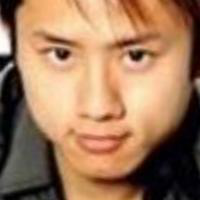

26 0


In [4]:
display(df['Images'][0])
print(df['Ages'][0], df['Genders'][0])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Ages', ylabel='Density'>

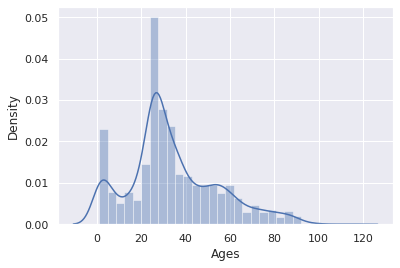

In [5]:
sns.set_theme()
sns.distplot(df['Ages'], bins=30)

In [6]:
len(df)

4000

In [7]:
x = []
y = []

for i in range(len(df)):
    df['Images'].iloc[i] = df['Images'].iloc[i].resize((200,200), Image.ANTIALIAS)
    ar = np.asarray(df['Images'].iloc[i])
    x.append(ar)
    agegen = [int(df['Ages'].iloc[i]), int(df['Genders'].iloc[i])]
    y.append(agegen)
x = np.array(x)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [8]:
y_age = df['Ages'] // 20
y_age = to_categorical(y_age, num_classes=6)

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2)

In [9]:
datagen = ImageDataGenerator(
    shear_range = 0.2, # random application of shearing
    zoom_range = 0.2, 
    horizontal_flip = True) 

In [10]:
from keras.applications.vgg19 import VGG19


base_model_vgg19 = VGG19(
    weights = 'imagenet',  
    input_shape=(200, 200, 3),
    include_top=False) 
for layer in base_model_vgg19.layers:
    layer.trainable = False
    
model_vgg19 = Sequential()
model_vgg19.add(base_model_vgg19)
model_vgg19.add(Flatten())
model_vgg19.add(Dense(6,activation='softmax'))
model_vgg19.summary()

2021-12-20 21:25:17.213726: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 21:25:17.299494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 21:25:17.300349: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 21:25:17.301472: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 6, 6, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 6)                 110598    
Total params: 20,134,982
Trainable params: 110,598
Non-trainable params: 20,024,384
_________________________________________________________________


In [11]:
model_vgg19.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", "mae"])

history_vgg19 = model_vgg19.fit_generator(datagen.flow(x_train_age, y_train_age, batch_size=32),
                   epochs=10,
                   verbose=1,
                   validation_data=(x_test_age, y_test_age))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-12-20 21:25:21.295796: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2021-12-20 21:25:22.952054: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


100/100 [==============================] - 37s 281ms/step - loss: 8.3057 - accuracy: 0.5622 - mae: 0.1461 - val_loss: 8.1269 - val_accuracy: 0.5763 - val_mae: 0.1425
Epoch 2/10
100/100 [==============================] - 27s 270ms/step - loss: 5.9477 - accuracy: 0.6656 - mae: 0.1121 - val_loss: 8.4563 - val_accuracy: 0.6450 - val_mae: 0.1202
Epoch 3/10
100/100 [==============================] - 27s 271ms/step - loss: 5.5221 - accuracy: 0.6950 - mae: 0.1021 - val_loss: 9.3499 - val_accuracy: 0.6137 - val_mae: 0.1299
Epoch 4/10
100/100 [==============================] - 28s 279ms/step - loss: 4.8514 - accuracy: 0.7391 - mae: 0.0874 - val_loss: 6.8757 - val_accuracy: 0.6150 - val_mae: 0.1271
Epoch 5/10
100/100 [==============================] - 28s 284ms/step - loss: 4.8047 - accuracy: 0.7416 - mae: 0.0856 - val_loss: 7.6533 - val_accuracy: 0.6288 - val_mae: 0.1230
Epoch 6/10
100/100 [==============================] - 28s 276ms/step - loss: 4.6957 - accuracy: 0.7666 - mae: 0.0785 - val_los